### Estrategy adopted:
Unite COMPLETE batches with the same uniqueid into a "measure". Each uniqueid will have N measures, being N the number of phases recorded at phase 0 for each uniqueid.

- Remove category columns that has 1 unique value ['site', 'division', 'category', 'line', 'model_name', 'recipe_group', 'product_code']
- Rename useful columns
- Remove INCOMPLETE measures
- Change phase names
- Transform each uniqueid in N measures
- Set the Densidad_max variable to target
- Delete Densidad_max values equals to 0
- Remove "uniqueid" column for training

In [593]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [594]:
# Read dataset

# read csv
df = pd.read_csv('FC_Mixer_MO.csv')

In [595]:
# Remove category columns that has 1 unique value

# First of all, let's remove every column that has the same value
# Check which columns have different values

columns_to_drop = []
for col in df.columns:
    unique = df[col].unique().shape[0]
    if unique == 1:
        
        columns_to_drop.append(col)

print(columns_to_drop)
df = df.drop(columns=columns_to_drop)

assert all(len(df[col].unique()) > 1 for col in df.columns)

['site', 'division', 'category', 'line', 'model_name', 'recipe_group', 'product_code']


In [596]:
# Rename useful columns
cols = ['id', 'complete', 'phase', 'time', 'value']
df = df.rename(columns={
    'uniqueid': 'id',
    'model_complete': 'complete',
    'char_name': 'phase',
    'char_time': 'time',
    'char_value': 'value'
})

assert all(a == b for a, b in zip(df.columns, cols))

In [597]:
# Remove INCOMPLETE measures

before = df.shape[0]
df = df[df['complete'] == 'COMPLETE']
after = df.shape[0]


print(f'Total rows removed: {before - after}')
assert len(df['complete'].unique()) == 1

In [598]:
df

,id,complete,phase,time,value
0,44168,COMPLETE,non_value_operating_time,2023-02-11 10:19:25,3560.000000
1,44168,COMPLETE,non_value_operating_time,2023-02-11 20:49:30,300.000000
2,44168,COMPLETE,non_value_operating_time,2023-02-12 04:28:05,190.000000
3,44168,COMPLETE,non_value_operating_time,2023-02-12 07:41:10,140.000000
4,44168,COMPLETE,non_value_operating_time,2023-02-12 15:19:00,640.000000
...,...,...,...,...,...
3641,47268,COMPLETE,phase_3.Recirculacion.Densidad_max,2023-03-31 14:27:10,58287.598000
3642,47268,COMPLETE,phase_3.Recirculacion.Presion_avg,2023-03-31 14:27:10,2.977007
3643,47268,COMPLETE,phase_3.Recirculacion.Presion_max,2023-03-31 14:27:10,2.989005
3644,47268,COMPLETE,phase_3.Recirculacion.Visco_max,2023-03-31 14:27:10,0.000000


In [599]:
df['phase'].unique()

array(['non_value_operating_time', 'phase_1.Inicio.duration',
       'phase_2.Medicion.duration', 'phase_3.Recirculacion.duration',
       'phase_3.Recirculacion.Peso_avg',
       'phase_3.Recirculacion.Densidad_max',
       'phase_3.Recirculacion.Presion_avg',
       'phase_3.Recirculacion.Presion_max',
       'phase_3.Recirculacion.Visco_max', 'total_duration'], dtype=object)

In [600]:
# Change phase names

df = df.replace('non_value_operating_time', 'phase_0')
df = df.replace('phase_1.Inicio.duration', 'phase_1')
df = df.replace('phase_2.Medicion.duration', 'phase_2')
df = df.replace('phase_3.Recirculacion.duration', 'duration')
df = df.replace('phase_3.Recirculacion.Peso_avg', 'peso_avg')
df = df.replace('phase_3.Recirculacion.Presion_avg', 'presion_avg')
df = df.replace('phase_3.Recirculacion.Presion_max', 'presion_max')
df = df.replace('phase_3.Recirculacion.Visco_max', 'visco_max')
df = df.replace('phase_3.Recirculacion.Densidad_max', 'densidad_max')

assert all(val != 'non_value_operating_time' for val in df['phase'])

In [601]:
df.columns

Index(['id', 'complete', 'phase', 'time', 'value'], dtype='object')

In [602]:
# Create cleaned dataframe

cleaned_columns = ['id', 'phase_0', 'phase_1', 'phase_2', 'duration', 'peso_avg', 'presion_avg', 'presion_max', 'visco_max', 'total_duration', 'densidad_max']

df_cleaned = pd.DataFrame(columns=cleaned_columns)
df_cleaned

,id,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max


In [603]:
# Transform each id in N measures
for id in df['id'].unique():
    cleaned = pd.DataFrame()
    df_unique = df[df['id'] == id]

    # Get the number of measures for each id
    n_measures = df_unique[df_unique["phase"] == "phase_0"].shape[0]


    # Transform each value of phase into a column
    for col in cleaned_columns[1:]:
        # Get the N first values of the measure
        np_values = df_unique[df_unique['phase']==col]['value'].head(n_measures)
        
        # Transform into a list
        values = list(np_values)

        # Insert into the dataframe
        try:
            cleaned[col] = values
        except ValueError:
            cleaned[col] = np.concatenate([values, [np.nan] * (len(cleaned) - len(values))])

    # assign the id to the dataframe
    cleaned['id'] = id

    # Concat with the main dataframe
    df_cleaned = pd.concat([df_cleaned, cleaned], ignore_index=True)

/tmp/ipykernel_15409/3313144002.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cleaned = pd.concat([df_cleaned, cleaned], ignore_index=True)


In [604]:
df_cleaned.head()

,id,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max
0,44168,3560.0,10.0,7370.0,10.0,0.0000,0.234332,0.234375,0.00000,7390.0,0.000
1,44168,300.0,335.0,5925.0,27985.0,4504.4478,1.237560,2.526042,559.38000,34245.0,63897.484
2,44168,190.0,115.0,10165.0,16935.0,5678.3500,1.288355,2.867477,579.17755,27215.0,66975.870
3,44168,140.0,40.0,8010.0,3345.0,29858.3710,1.915336,3.003472,717.00000,11395.0,62665.250
4,44168,640.0,115.0,5785.0,21430.0,4409.2380,1.260862,2.881945,900.00000,27330.0,64876.690


In [605]:
# # Delete Densidad_max values equals to 0

# df_cleaned = df_cleaned.loc[df_cleaned['densidad_max'] > 0]

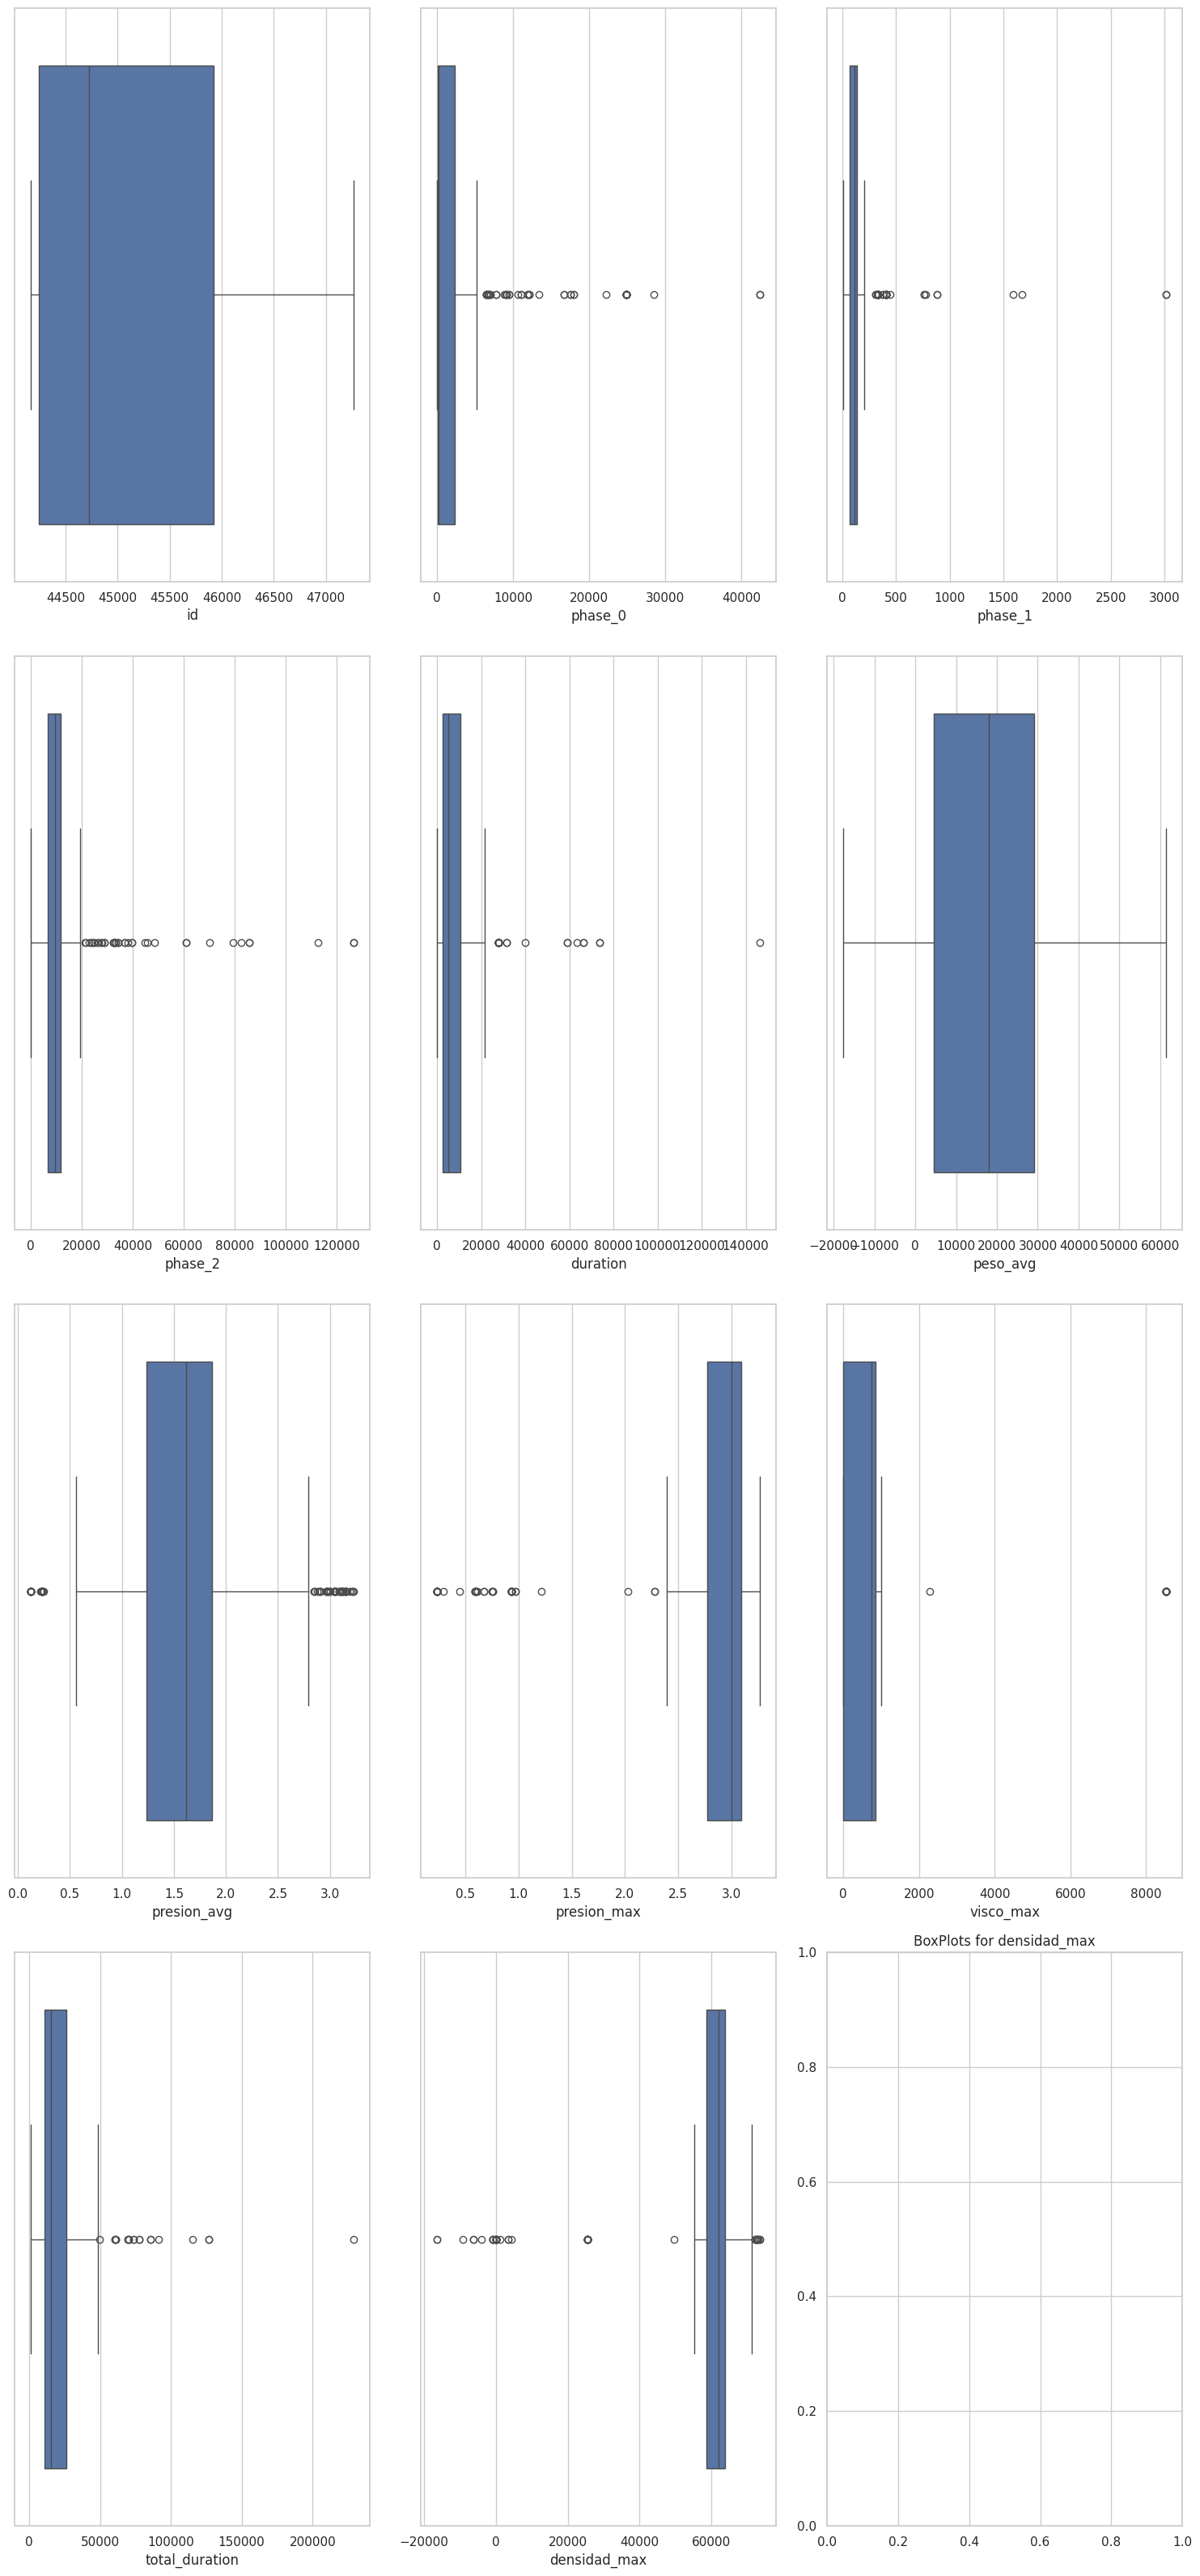

In [606]:
# Configurações do gráfico

rows=4
cols=3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*8))

cc = 0
for i in range(rows):
    for j in range(cols):
        if cc >= len(df_cleaned.columns):
            break
        plt.title(f'BoxPlots for {df_cleaned.columns[cc]}')
        sns.boxplot(df_cleaned, x=df_cleaned.columns[cc], ax=axes[i][j])
        cc+=1

plt.tight_layout()
plt.show()



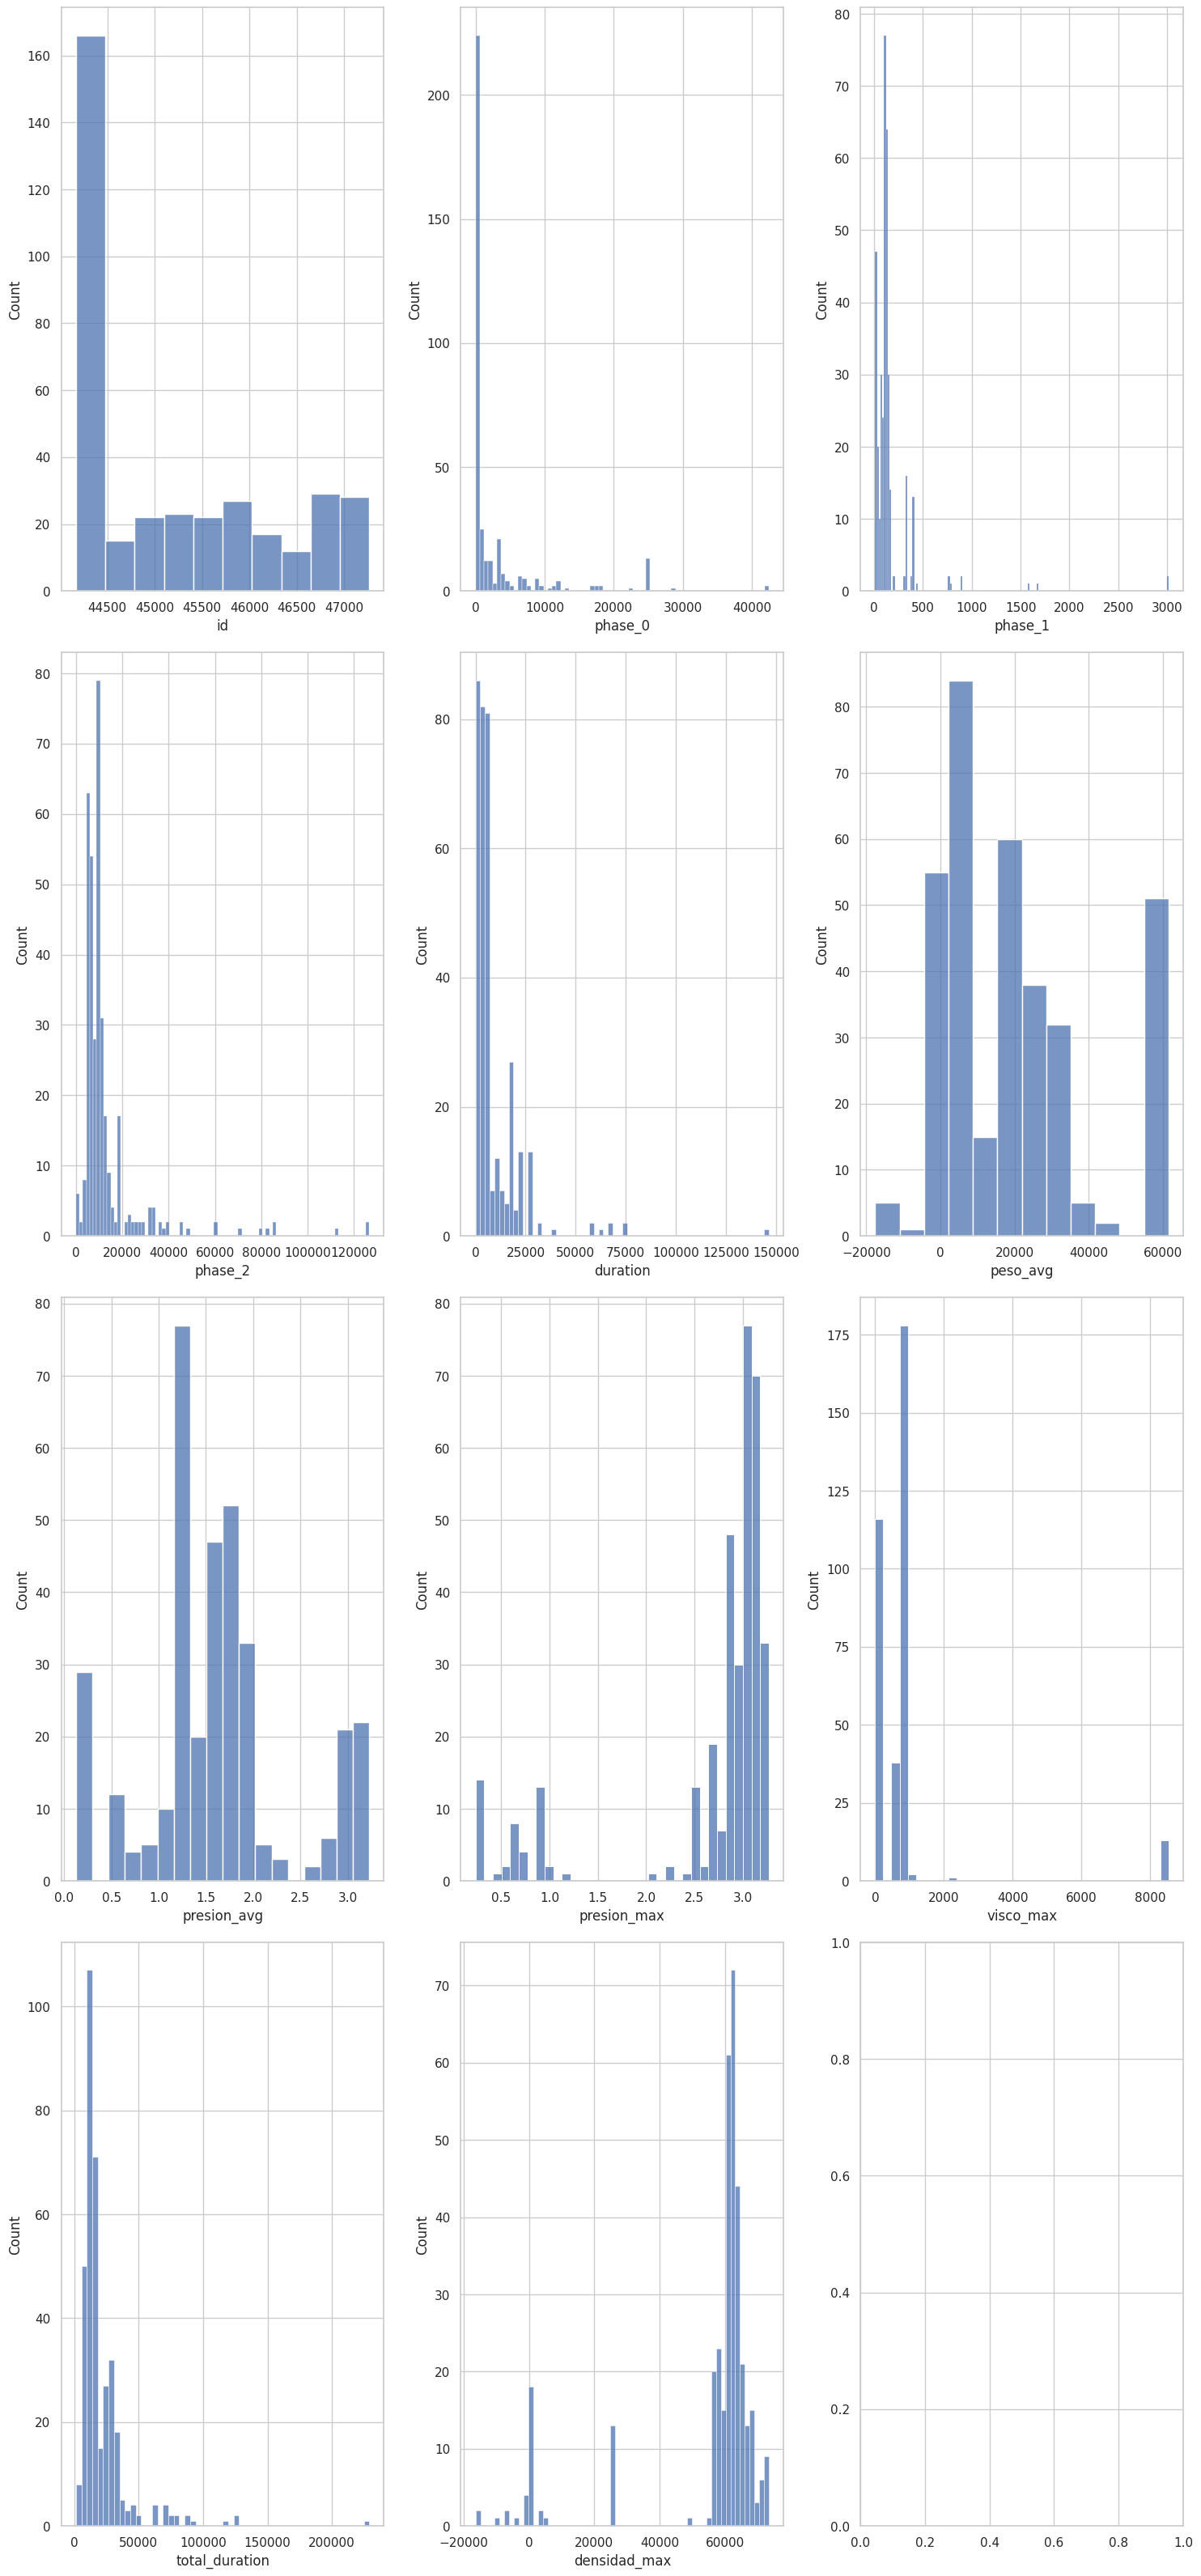

In [607]:
# Configurações do gráfico

rows=4
cols=3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*8))

cc = 0
for i in range(rows):
    for j in range(cols):
        if cc >= len(df_cleaned.columns):
            break
        sns.histplot(df_cleaned, x=df_cleaned.columns[cc], ax=axes[i][j])
        cc+=1

plt.tight_layout()
plt.show()



In [608]:
df_cleaned.sort_values(by='total_duration', ascending=False)

,id,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max
171,44513,205.0,30.0,82560.0,146435.0,512.72675,1.159775,2.905093,0.0,229025.0,63733.6800
199,44994,9480.0,120.0,126595.0,10.0,-922.48895,0.965800,0.969329,0.0,126725.0,-842.2456
197,44972,9480.0,120.0,126595.0,10.0,-922.48895,0.965800,0.969329,0.0,126725.0,-842.2456
306,46680,240.0,1590.0,112475.0,1310.0,57095.34800,2.734593,2.887407,0.0,115375.0,62947.9800
160,44339,215.0,10.0,79175.0,12365.0,194.22350,1.041677,3.146355,0.0,91550.0,57672.4960
...,...,...,...,...,...,...,...,...,...,...,...
229,45495,105.0,885.0,50.0,1025.0,-1025.67020,0.760105,0.760995,0.0,1960.0,-943.7849
231,45529,105.0,885.0,50.0,1025.0,-1025.67020,0.760105,0.760995,0.0,1960.0,-943.7849
291,46299,13365.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,1475.0,NaN
249,45743,2025.0,10.0,1230.0,25.0,0.00000,0.601852,0.601852,0.0,1265.0,0.0000


In [609]:
# Remove NaN Values

before = df_cleaned.shape[0]
df_cleaned = df_cleaned.dropna()
after = df_cleaned.shape[0]

print(f'Total rows removed: {before - after}')

Total rows removed: 13


In [610]:
# Remove duplicate values

before = df_cleaned.shape[0]
df_cleaned = df_cleaned.drop_duplicates(subset=['peso_avg', 'presion_avg', 'presion_max', 'visco_max'])
after = df_cleaned.shape[0]

print(f'Total rows removed: {before - after}')

Total rows removed: 205


The dataset keeps repeting itself from time to time, this may be because the data was augmented or the values are really the same.

The visco_max column has some random numbers that probably indicates an error

We will transform those numbers in a close percentile max or min

In [611]:
df_cleaned.describe()

,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2811.923077,165.104895,14864.720280,7814.650350,24611.196566,1.801226,2.772291,508.761281,22610.174825,56148.500681
std,5913.023282,323.308419,18104.041644,16660.373145,22021.012466,0.817686,0.727341,799.633654,26187.786641,18528.165203
min,0.000000,10.000000,25.000000,10.000000,-17615.346000,0.125097,0.234375,0.000000,1265.000000,-16388.299000
25%,152.500000,75.000000,6917.500000,172.500000,5527.272800,1.234549,2.864584,0.000000,10955.000000,57764.423500
50%,250.000000,110.000000,9745.000000,3520.000000,18800.367000,1.651462,3.031706,674.461900,15040.000000,61629.110000
75%,2425.000000,132.500000,13397.500000,6635.000000,41432.092000,2.226299,3.123356,820.871000,23277.500000,63088.531500
max,42460.000000,3015.000000,126595.000000,146435.000000,61444.620000,3.228009,3.269676,8530.000000,229025.000000,73526.016000


In [612]:
# Repair visco_max

# High values
percentile_95 = np.percentile(df_cleaned['visco_max'], 95)
df_cleaned['visco_max'] = np.where(df_cleaned['visco_max'] > 8000, percentile_95, df_cleaned['visco_max'] )

# Low or 0 values
percentile_5 = np.percentile(df_cleaned['visco_max'], 5)
df_cleaned['visco_max'] = np.where(df_cleaned['visco_max'] <= 0, percentile_5, df_cleaned['visco_max'] )

In [613]:
# Repair densidad_max

# Low or 0 values
percentile_5 = np.percentile(df_cleaned['densidad_max'], 5)
df_cleaned['densidad_max'] = np.where(df_cleaned['densidad_max'] <= 0, percentile_5, df_cleaned['densidad_max'] )

More than 25% of visco_max values are 0.
Maybe it's an big error or maybe it's a common value.

### Testes de Correlação de variáveis

In [614]:
df_cleaned.describe()

,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2811.923077,165.104895,14864.720280,7814.650350,24611.196566,1.801226,2.772291,455.397645,22610.174825,56411.540338
std,5913.023282,323.308419,18104.041644,16660.373145,22021.012466,0.817686,0.727341,429.555805,26187.786641,17623.527101
min,0.000000,10.000000,25.000000,10.000000,-17615.346000,0.125097,0.234375,0.000000,1265.000000,0.000000
25%,152.500000,75.000000,6917.500000,172.500000,5527.272800,1.234549,2.864584,0.000000,10955.000000,57764.423500
50%,250.000000,110.000000,9745.000000,3520.000000,18800.367000,1.651462,3.031706,674.461900,15040.000000,61629.110000
75%,2425.000000,132.500000,13397.500000,6635.000000,41432.092000,2.226299,3.123356,820.871000,23277.500000,63088.531500
max,42460.000000,3015.000000,126595.000000,146435.000000,61444.620000,3.228009,3.269676,2281.717000,229025.000000,73526.016000


In [615]:
df_cleaned.corr()

,id,phase_0,phase_1,phase_2,duration,peso_avg,presion_avg,presion_max,visco_max,total_duration,densidad_max
id,1.000000,-0.038535,-0.032192,-0.079960,-0.195260,0.445115,0.448794,0.167708,-0.243471,-0.175284,0.074325
phase_0,-0.038535,1.000000,0.040552,0.038301,-0.010642,-0.023495,-0.029463,-0.053886,-0.012668,0.018159,0.030345
phase_1,-0.032192,0.040552,1.000000,0.131667,-0.049384,0.035310,0.030926,0.036463,0.047755,0.068883,0.024145
phase_2,-0.079960,0.038301,0.131667,1.000000,0.129803,0.106390,0.114084,-0.042348,-0.361564,0.770973,-0.099255
duration,-0.195260,-0.010642,-0.049384,0.129803,1.000000,-0.358571,-0.280496,0.107302,0.228004,0.727448,0.180756
peso_avg,0.445115,-0.023495,0.035310,0.106390,-0.358571,1.000000,0.965971,0.438379,-0.318308,-0.153467,0.325725
presion_avg,0.448794,-0.029463,0.030926,0.114084,-0.280496,0.965971,1.000000,0.558854,-0.266734,-0.092441,0.398519
presion_max,0.167708,-0.053886,0.036463,-0.042348,0.107302,0.438379,0.558854,1.000000,0.333829,0.051918,0.905168
visco_max,-0.243471,-0.012668,0.047755,-0.361564,0.228004,-0.318308,-0.266734,0.333829,1.000000,-0.096195,0.421408
total_duration,-0.175284,0.018159,0.068883,0.770973,0.727448,-0.153467,-0.092441,0.051918,-0.096195,1.000000,0.054613


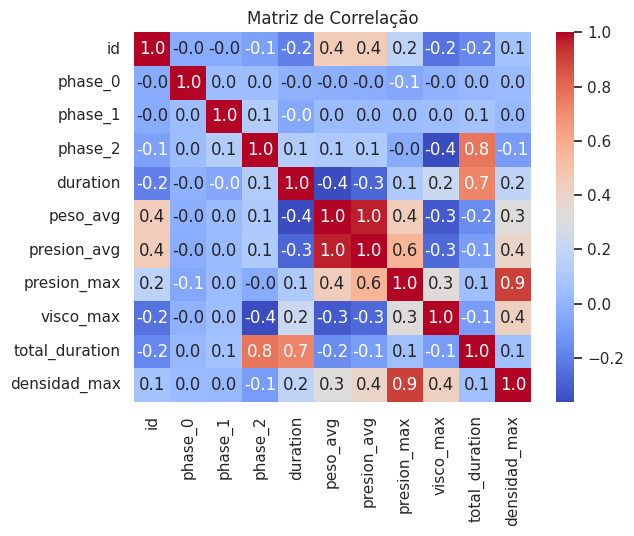

In [616]:
plt.title('Matriz de Correlação')
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.show()

Now with the dataset defined, it is possible to create a regression model for it

input features that have a strong enough correlation to train the model:
- peso_avg
- presion_avg
- presion_max
- visco_max

In [617]:
# Save cleaned dataset

df_cleaned.to_csv('cleaned_data.csv')
print(f'Dataset final shape:')
df_cleaned.shape

Dataset final shape:


(143, 11)